In [23]:
from libraries import MyDAQ
from libraries import functions as H
import matplotlib.pyplot as plt
import numpy as np
import nidaqmx as dx
from scipy.signal import sawtooth, square
import libraries
from libraries import PMConverter
from scipy.fft import rfft, rfftfreq, irfft
import time
all_list = [H.RC_C]

PM = PMConverter()
daq = MyDAQ()
daq.name = 'MyDAQ1'
daq.samplerate = 200000
read_channel = ['AI0', 'AI1']	
write_channel = 'AO0'

In [24]:
frequencies = np.array([1000, 20000])#  np.logspace(0, 5, 100)
print(frequencies)
t, signal = daq.generateMultipleWaveforms('sine', frequencies, 6, 0, 8, daq.samplerate)
signal /= np.max(np.abs(signal)) * 8


[ 1000 20000]


In [25]:
data0, data1 = daq.readwrite(signal, read_channel, write_channel)

DaqError: Device identifier is invalid.
Device Specified: MyDAQ1

Task Name: write

Status Code: -200220

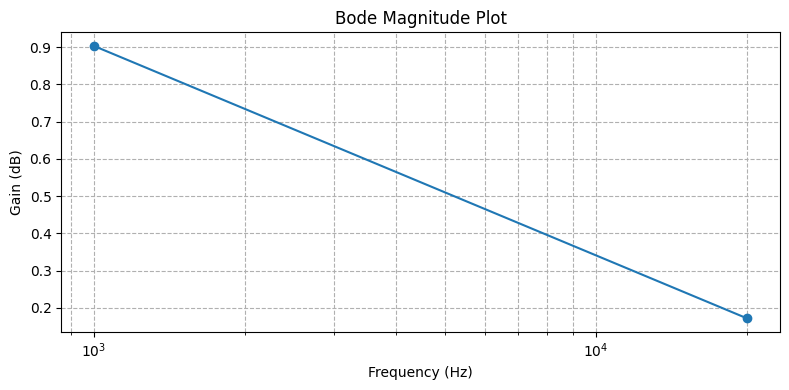

In [26]:
DAs = []
DPs = []
AAs = []
APs = []
for f in frequencies:
    A, P = PM.lock_in_amplifier(data0, daq.samplerate, f, t)
    DAs.append(A)
    DPs.append(P)

    A, P = PM.lock_in_amplifier(data1, daq.samplerate, f, t)
    AAs.append(A)
    APs.append(P)

gains = np.asarray(AAs) / np.asarray(DAs)

plt.figure(figsize=(8, 4))
plt.semilogx(frequencies, gains, marker='o')  # semilog x-axis
plt.title('Bode Magnitude Plot')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.grid(True, which='both', linestyle='--')
plt.tight_layout()
plt.show()


In [27]:
import pyvisa
rm = pyvisa.ResourceManager()
print(rm.list_resources())


('USB0::0xF4ED::0xEE3A::SDG08CBX7R0701::INSTR', 'USB0::0x1AB1::0x0588::DS1ED142005505::INSTR', 'ASRL3::INSTR', 'ASRL4::INSTR')


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pyvisa
import time

rm = pyvisa.ResourceManager()
sdg = rm.open_resource(rm.list_resources()[0])  # Your SDG830 resource
rigol = rm.open_resource(rm.list_resources()[1])  # Your DS1052E resource

def set_sine(freq, amplitude=1.0):
    sdg.write(f'C1:BSWV FRQ,{freq},AMP,{amplitude},OFST,0,PHSE,0')

def measure_rigol():
    rigol.write(':STOP')
    rigol.write(':WAV:DATA? CHAN1')
    raw = rigol.read_raw()[10:]  # Remove header
    data = np.frombuffer(raw, dtype=np.uint8)
    voltages = (data - 130) * 0.02  # Approximate voltage scaling
    return voltages

frequencies = np.logspace(1, 5, 50)  # 10 Hz to 100 kHz
transfer = []

for f in frequencies:
    set_sine(f, 5)
    time.sleep(0.5)  # wait for system to stabilize

    vin = measure_rigol()  # You need to be measuring CH1=Vin
    vout = measure_rigol()  # CH2=Vout, if available
    print(vin)
    print(vout)
    # Compute amplitudes (e.g., RMS or peak-to-peak)
    vin_amp = (np.max(vin) - np.min(vin)) / 2
    vout_amp = (np.max(vout) - np.min(vout)) / 2

    H = vout_amp / vin_amp
    transfer.append(H)

# Plot transfer function
plt.semilogx(frequencies, 20 * np.log10(transfer))  # in dB
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.title("Measured Transfer Function")
plt.grid(True)
plt.show()


VisaIOError: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).